In [1]:
import numpy as np
from vpsto.vptraj import VPTraj

import matplotlib.pyplot as plt
from matplotlib import animation

%load_ext autoreload
%autoreload 2

In [2]:
q0 = np.array([-.5, -.5]) # Initial position
qg = np.array([.5, .5]) # Goal position
dq0 = np.array([0, 0]) # Initial velocity
dqg = np.array([0, 0]) # Goal velocity

bounds = 0.8*np.array([[-1, 1], [-1, 1]]) # Bounds on position

R = 1e1 # Penalty on control effort (acceleration)
Q_min = 1e0 # Minimum penalty on control error (position)
Q_max = 1e3 # Maximum penalty on control error (position)
factor_Q_min = 1e-2
factor_Q_max = 1e1

N_via = 4 # Number of via points
N_candidates = 1000 # Number of candidates to sample
N_eval = 50 # Number of pos,vel,acc samples to evaluate along each candidate trajectory

vel_lim = 0.4 # Velocity limit (m/s in each dimension)
acc_lim = 1 # Acceleration limit (m/s^2 in each dimension)

num_obstacles = 10 # Number of obstacles
robot_radius = 0.1 # Radius of robot (m)
obstacle_radius = 0.1 # Radius of obstacle (m)

dt_control = 0.05 # Time step for control (s)
sim_duration = 10 # Duration of simulation (s)

In [3]:
class Obstacle:
    def __init__(self, pos, vel, radius, robot_radius):
        self.pos = pos # initial position
        self.vel = vel # initial velocity
        self.radius = radius # radius of obstacle
        self.robot_radius = robot_radius # radius of robot
        self.d_sq = (radius + robot_radius + 0.01)**2 # distance squared for faster collision checking

        self.history = [self.pos.copy()] # history of obstacle positions

    def reset(self):
        self.history = [self.pos.copy()]

    def step(self, dt):
        # Check if obstacle would bounce off a wall and reverse velocity if so
        for i in range(2):
            if self.pos[i] + self.vel[i] * dt < bounds[i, 0] + self.radius:
                self.vel[i] = -self.vel[i]
            if self.pos[i] + self.vel[i] * dt > bounds[i, 1] - self.radius:
                self.vel[i] = -self.vel[i]
        self.pos += self.vel * dt
        self.history.append(self.pos.copy())

    def is_collision(self, robot_pos):
        # Check if the robot at pos is in collision with the obstacle
        # pos is a (N+1)D array of shape (M1, ..., MN, 2)
        # Returns a ND array of shape (M1, ..., MN) containing True if there is a collision
        return np.sum((robot_pos - self.pos)**2, axis=-1) < self.d_sq
    
    def predict_collision(self, robot_pos_traj, T):
        # Predict if there will be a collision in the next T seconds
        # pos_traj is a 2D array of shape (N, 2) containing the discretized trajectory of the robot
        # T is a scalar
        # Returns the number of collisions in the next T seconds
        N = robot_pos_traj.shape[0]
        t_traj = np.linspace(0, T, N)
        obs_traj = self.pos + self.vel * t_traj[:, None]
        return np.sum((robot_pos_traj - obs_traj)**2, axis=-1) < self.d_sq
    
    def predict_collision_batch(self, robot_pos_traj, T):
        # Predict if there will be a collision in the next T seconds
        # pos_traj is a 3D array of shape (N_batch, N, 2) containing the discretized trajectories of the robot
        # T is a vector of shape (N_batch,)
        # Returns the number of collisions in the next T seconds for each batch element
        N_batch, N, _ = robot_pos_traj.shape
        t_traj = np.linspace(0, T, N)
        obs_traj = self.pos + np.swapaxes(self.vel * t_traj[:, :, None], 0, 1) # (N_batch, N, 2)
        return np.sum((robot_pos_traj - obs_traj)**2, axis=-1) < self.d_sq

In [4]:
class PredictiveSamplingController:
    def __init__(self, N_eval, N_via, vel_lim, acc_lim, bounds, qg, obstacles, dt_control, N_candidates, R):
        self.vptraj = VPTraj(ndof=2, N_eval=N_eval, N_via=N_via, vel_lim=vel_lim, acc_lim=acc_lim)
        self.vptraj_idle = VPTraj(ndof=2, N_eval=N_eval, N_via=1, vel_lim=vel_lim, acc_lim=acc_lim)

        self.bounds = bounds # Bounds on position
        self.qg = qg # Goal position
        self.obstacles = obstacles # List of obstacles to avoid
        self.dt_control = dt_control # Time step for control
        self.N_candidates = N_candidates # Number of candidate trajectories to sample
        self.R = R # Acceleration penalty at sampling stage (not considered in loss function)
        self.Q = Q_max # Bias towards trajectories that go closer to the goal (updated at each iteration)
        self.dQ_max = 1.5
        self.acc_lim = acc_lim # Acceleration limit (used for constructing idle trajectory)

        self.p_next = None # Candidate trajectory parameter for next iteration
        self.T_next = None # Candidate trajectory duration for next iteration
        self.samples_log = [] # Log of all candidate trajectories
        self.samples_loss_log = [] # Log of all candidate trajectories' losses
        self.sol_log = [] # Log of all solutions
        self.Q_log = [] # Log of all Q values

    def reset(self):
        self.p_next = None
        self.T_next = None
        self.samples_log = []
        self.samples_loss_log = []
        self.sol_log = []
        self.Q_log = []

    # Loss function for the candidate trajectories
    def loss_fn(self, q, dq, ddq, T):
        # Penalize trajectory duration
        duration_cost = T
        # Penalize control error
        qT = q[:,-1] # Final position of all candidates
        terminal_cost = 1e3 * np.sum((qT - self.qg)**2, axis=1) # Squared error
        # Penalize position limit violations (soft constraint)
        num_violations = np.sum((q < self.bounds[:,0] + robot_radius) | (q > self.bounds[:,1] - robot_radius), axis=(1,2))
        limit_violation_cost = 1e6 * num_violations
        # Penalize collisions with the obstacles (soft constraint)
        collision_cost = 0
        for obs in self.obstacles:
            collision_cost += 1e6 * np.sum(obs.predict_collision_batch(q, T), axis=1)

        return terminal_cost + limit_violation_cost + duration_cost + collision_cost
    
    # Control function that samples candidate trajectories and chooses the best one
    def predictive_sampling(self, q, dq):
        # Compute how many constraint violations have occurred in the previous iteration
        if len(self.samples_loss_log) > 0:
            num_violations = np.sum(self.samples_loss_log[-1] > 1e6)
        else:
            num_violations = 0
        # Compute how strong the bias should be towards the goal:
        # - If there have been few constraint violations, increase the bias
        # - If there have been many constraint violations, decrease the bias
        self.Q *= np.clip(np.exp(-3 * (num_violations/self.N_candidates-0.5)), 1/self.dQ_max, self.dQ_max)
        self.Q = np.clip(self.Q, Q_min, Q_max)
        self.Q_log.append(self.Q)

        # Sample candidate trajectories, compute their loss and return the best one
        pos, vel, acc, p, T = self.vptraj.sample_trajectories(self.N_candidates, q, dq0=dq, qT=self.qg, 
                                                              dqT=np.zeros_like(dq), Q=self.Q, R=self.R)
        loss = self.loss_fn(pos[:,1:], vel[:,1:], acc[:,1:], T)
        self.samples_log.append(pos)
        self.samples_loss_log.append(loss)
        i_best = np.argmin(loss)
        return p[i_best], loss[i_best], T[i_best]
    
    # Control function that reuses the previous solution
    def previous_sol(self, q, dq):
        if self.p_next is None:
            return None, np.inf, 0
        # Compute trajectory with previous solution
        pos, vel, acc = self.vptraj.get_trajectory(self.p_next, q, dq0=dq, dqT=np.zeros_like(dq), T=self.T_next)
        loss = self.loss_fn(pos[:,1:], vel[:,1:], acc[:,1:], [self.T_next])[0]
        return self.p_next, loss, self.T_next
    
    # Control function that makes the robot come to stop as fast as possible
    def idle(self, q, dq):
        # Assuming constant acceleration
        T_idle = np.max(np.abs(dq) / self.acc_lim)
        # Compute the stopping position
        q_idle = q + 0.5 * dq * T_idle
        pos, vel, acc = self.vptraj_idle.get_trajectory(q_idle, q, dq0=dq, dqT=np.zeros_like(dq), T=T_idle)
        loss = self.loss_fn(pos[:,1:], vel[:,1:], acc[:,1:], [T_idle])[0]
        # Check obstacle collision also for two seconds ahead
        q_list = np.vstack((q, q_idle))
        loss += 1e6 * np.sum([obs.predict_collision(q_list, T_idle + 2) for obs in self.obstacles])
        t_next = np.min([T_idle, self.dt_control])
        if t_next < dt_control:
            return q_idle, np.zeros_like(dq), loss, 0
        q_next, dq_next, _ = self.vptraj_idle.get_trajectory_at_time(t_next, q_idle, q, dq0=dq, dqT=np.zeros_like(dq), T=T_idle)
        return q_next.squeeze(), dq_next.squeeze(), loss, T_idle
    
    def control(self, q, dq):
        # Compute idle trajectory
        q_next_idle, dq_next_idle, loss_idle, T_idle = self.idle(q, dq)
        # Compute trajectory with previous solution
        p_prev, loss_prev, T_prev = self.previous_sol(q, dq)
        # Compute trajectory with predictive sampling
        p_samp, loss_samp, T_samp = self.predictive_sampling(q, dq)
        # q_next, dq_next, _ = self.vptraj.get_trajectory_at_time(dt_control, p_samp, q, dq0=dq, 
        #                                                         dqT=np.zeros_like(dq), T=T_samp)
        # self.sol_log.append(q_next)

        # return q_next[0], dq_next[0]

        # # Choose the best trajectory
        if loss_idle < loss_prev and loss_idle < loss_samp:
            self.p_next = None
            self.T_next = None
            loss_best = loss_idle
            self.sol_log.append(np.vstack((q, q_next_idle)))
            return q_next_idle, dq_next_idle
        elif loss_prev < loss_samp:
            p_best = p_prev
            T_best = T_prev
            loss_best = loss_prev
        else:
            p_best = p_samp
            T_best = T_samp
            loss_best = loss_samp
        if T_best < self.dt_control:
            self.p_next = None
            self.T_next = None
            self.sol_log.append(np.vstack((q, q)))
            return p_best[-self.vptraj.ndof:], np.zeros_like(dq)
        # Compute trajectory parameter and duration for next time step
        self.T_next = T_best - self.dt_control
        t_next = np.linspace(0, self.T_next, self.vptraj.N_via+1) + self.dt_control
        q_next, dq_next, _ = self.vptraj.get_trajectory_at_time(t_next, p_best, q, dq0=dq, 
                                                                dqT=np.zeros_like(dq), T=T_best)
        self.p_next = q_next[1:].flatten()
        self.sol_log.append(q_next)

        return q_next[0], dq_next[0]

### Initialize obstacles and controller

In [5]:
# Initialize obstacles at random positions and velocities
obstacles = []
for i in range(num_obstacles):
    valid = False
    while not valid:
        pos = np.random.uniform(bounds[:, 0] + obstacle_radius, bounds[:, 1] - obstacle_radius)
        vel = np.random.uniform(-.1, .1, size=2)
        obs = Obstacle(pos, vel, obstacle_radius, robot_radius)
        valid = not obs.is_collision(q0)
    obstacles.append(obs)

In [6]:
controller = PredictiveSamplingController(N_eval, N_via, vel_lim, acc_lim, bounds, qg, obstacles, dt_control, N_candidates, R)

In [7]:
%%timeit
pos, vel, acc, p, T = controller.vptraj.sample_trajectories(controller.N_candidates, q0, dq0=dq0, qT=controller.qg, 
                                                        dqT=np.zeros_like(dq0), Q=controller.Q, R=controller.R)
loss = controller.loss_fn(pos[:,1:], vel[:,1:], acc[:,1:], T)

73.3 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Simulate closed-loop system for *sim_duration* seconds

In [8]:
q_sim = [q0]
dq_sim = [dq0]

I = int(sim_duration / dt_control)
for i in range(I):
    print(i/I, end='\r')
    for obs in obstacles:
        obs.step(dt_control) # Simulate obstacle motion
    q, dq = controller.control(q_sim[-1], dq_sim[-1]) # Compute next desired position and velocity
    # As we pretend we have a perfect low-level controller, we can directly apply the desired state
    q_sim.append(q.copy()) 
    dq_sim.append(dq.copy())

q_sim = np.array(q_sim)[1:]
dq_sim = np.array(dq_sim)[1:]

In [9]:
%%timeit
for obs in obstacles:
    obs.step(dt_control) # Simulate obstacle motion

60.2 µs ± 9.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%%timeit
q, dq = controller.control(q_sim[-1], dq_sim[-1]) # Compute next desired position and velocity

76.2 ms ± 4.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
q_next, dq_next, _ = controller.vptraj.get_trajectory_at_time(dt_control, np.zeros(N_via*2), q0, dq0=dq0, 
                                                        dqT=np.zeros_like(dq0), T=1)

723 µs ± 89.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Visualize results

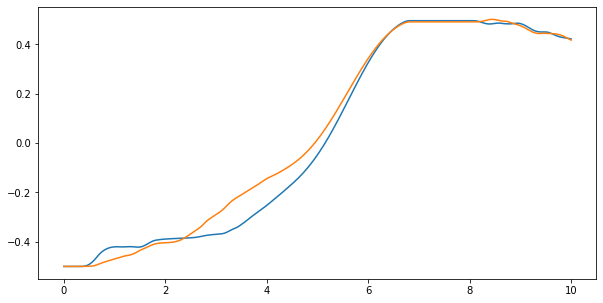

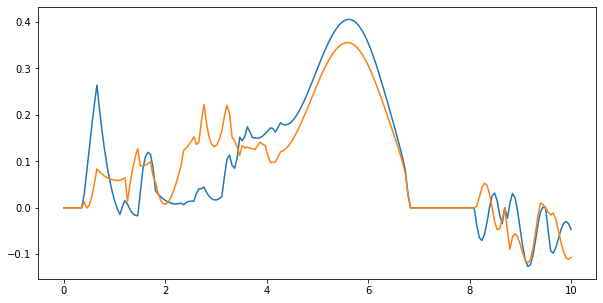

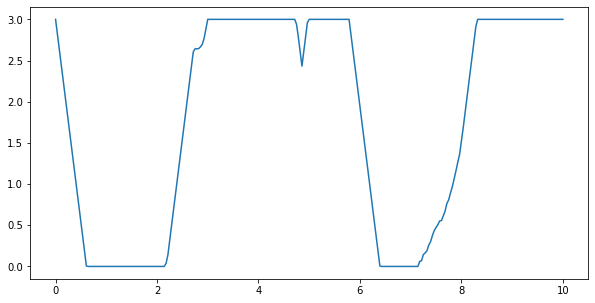

In [12]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, sim_duration, len(q_sim)), q_sim)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, sim_duration, len(dq_sim)), dq_sim)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0, sim_duration, len(controller.Q_log)), np.log10(controller.Q_log))

fps = 30

# Animate the simulation
fig = plt.figure(figsize=(10,10), dpi=200)
ax = plt.gca()
ax.set_facecolor('k')
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
ax.set_xticks([])
ax.set_yticks([])

obstacle_paches = []
for obs in obstacles:
    obstacle_paches.append(plt.Circle(obs.pos, obs.radius, color='gray', alpha=.5))
    ax.add_patch(obstacle_paches[-1])

robot_patch = plt.Circle(q0, robot_radius, color='w', label='Robot')
ax.add_patch(robot_patch)
plt.scatter(qg[0], qg[1], c='w', marker='x', s=100, label='Goal')

pred_line, = ax.plot([], [], 'm', lw=2.5, label='Simulated trajectory', zorder=10)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='w', fontsize=14)

# create a plot for each sample in samples_log
sample_lines = []
for i in range(N_candidates):
    line, = ax.plot([], [], 'g', alpha=.25)
    sample_lines.append(line)

def init():
    pred_line.set_data([], [])
    time_text.set_text('')
    return pred_line, time_text

def animate(i_):
    i = np.min([len(q_sim)-1, int(i_ / (dt_control * fps))])
    pred_line.set_data(controller.sol_log[i][:,0], controller.sol_log[i][:,1])
    robot_patch.center = q_sim[i]
    print(int(i/len(q_sim)*100), end='%\r')
    for j, obs in enumerate(obstacles):
        obstacle_paches[j].center = obs.history[i]
    loss = controller.samples_loss_log[i]
    rewards = 1 - (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    for j in range(N_candidates):
        sample_lines[j].set_data(controller.samples_log[i][j,:,0], controller.samples_log[i][j,:,1])
        sample_lines[j].set_color((1-rewards[j], rewards[j], 0))
    time_text.set_text('time = %.1f' % (i*dt_control))
    return pred_line, time_text

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(len(q_sim) * dt_control * fps), interval=1e3/fps, blit=True)

anim.save('animation.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])